In [1]:
import argparse
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import functional as F

from torchvision import datasets, transforms, utils

from scheduler import CycleScheduler

# Data

In [2]:
class vid_faces(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, transform=None):

        self.filenames = glob.glob('/home/jarrod/dev/vq-vae-2-pytorch/256_train_data/*vid*.npy')
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
          
        img = torch.Tensor(np.load(self.filenames[idx]))
        aud = torch.Tensor(np.load(self.filenames[idx].split('_vid_')[0] + '_aud_' + self.filenames[idx].split('_vid_')[1]))
        
        fn = self.filenames[idx].split('_')
        fn = fn[0] + '_' + fn[1] + '_' + fn[2] + '_' + fn[3] + '_0_id.npy'
        
        id_img = torch.Tensor(np.load(fn))
        
        img = img.permute(2,0,1)
        id_img = id_img.permute(2,0,1)
        
        sample = {'id': id_img, 'image': img, 'audio': aud, 'fname':self.filenames[idx]}

        return sample

In [3]:
# grab the names of the pre-processed video files

# build datasets
dataset = vid_faces()
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=16)

# Model

In [4]:
class Quantize(nn.Module):
    def __init__(self, dim, n_embed, decay=0.99, eps=1e-5):
        super().__init__()

        self.dim = dim
        self.n_embed = n_embed
        self.decay = decay
        self.eps = eps

        embed = torch.randn(dim, n_embed)
        self.register_buffer('embed', embed)
        self.register_buffer('cluster_size', torch.zeros(n_embed))
        self.register_buffer('embed_avg', embed.clone())

    def forward(self, x):
        flatten = x.reshape(-1, self.dim)
        dist = (
            flatten.pow(2).sum(1, keepdim=True)
            - 2 * flatten @ self.embed
            + self.embed.pow(2).sum(0, keepdim=True)
        )
        _, embed_ind = (-dist).max(1)
        embed_onehot = F.one_hot(embed_ind, self.n_embed).type(flatten.dtype)
        embed_ind = embed_ind.view(*x.shape[:-1])
        quantize = self.embed_code(embed_ind)

        if self.training:
            self.cluster_size.data.mul_(self.decay).add_(
                1 - self.decay, embed_onehot.sum(0)
            )
            embed_sum = flatten.transpose(0, 1) @ embed_onehot
            self.embed_avg.data.mul_(self.decay).add_(1 - self.decay, embed_sum)
            n = self.cluster_size.sum()
            cluster_size = (
                (self.cluster_size + self.eps) / (n + self.n_embed * self.eps) * n
            )
            embed_normalized = self.embed_avg / cluster_size.unsqueeze(0)
            self.embed.data.copy_(embed_normalized)

        diff = (quantize.detach() - x).pow(2).mean()
        quantize = x + (quantize - x).detach()

        return quantize, diff, embed_ind

    def embed_code(self, embed_id):
        return F.embedding(embed_id, self.embed.transpose(0, 1))


class ResBlock(nn.Module):
    def __init__(self, in_channel, channel):
        super().__init__()

        self.conv = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channel, channel, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channel, in_channel, 1),
        )

    def forward(self, x):
        out = self.conv(x)
        out += x

        return out


class Encoder(nn.Module):
    def __init__(self, in_channel, channel, n_res_block, n_res_channel, stride):
        super().__init__()

        if stride == 4:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel, channel, 3, padding=1),
            ]

        elif stride == 2:
            blocks = [
                nn.Conv2d(in_channel, channel // 2, 4, stride=2, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(channel // 2, channel, 3, padding=1),
            ]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class Decoder(nn.Module):
    def __init__(
        self, in_channel, out_channel, channel, n_res_block, n_res_channel, stride
    ):
        super().__init__()
        
        blocks = [nn.Conv2d(in_channel, channel, 3, padding=1)]

        for i in range(n_res_block):
            blocks.append(ResBlock(channel, n_res_channel))

        blocks.append(nn.ReLU(inplace=True))

        if stride == 4:
            blocks.extend(
                [
                    nn.ConvTranspose2d(channel, channel // 2, 4, stride=2, padding=1),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(
                        channel // 2, out_channel, 4, stride=2, padding=1
                    ),
                ]
            )

        elif stride == 2:
            blocks.append(
                nn.ConvTranspose2d(channel, out_channel, 4, stride=2, padding=1)
            )

        self.blocks = nn.Sequential(*blocks)

    def forward(self, x):
        return self.blocks(x)


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channel=3,
        channel=128,
        n_res_block=2,
        n_res_channel=32,
        embed_dim=64,
        n_embed=512,
        decay=0.99,
    ):
        super().__init__()

        self.enc_aud = audEncoder()
        
        self.enc_b = Encoder(in_channel, channel, n_res_block, n_res_channel, stride=4)
        self.enc_t = Encoder(channel, channel, n_res_block, n_res_channel, stride=2)
        
        self.quantize_conv_t = nn.Conv2d(channel, embed_dim, 1)
        self.quantize_t = Quantize(embed_dim, n_embed)
        
        self.dec_t = Decoder(embed_dim, embed_dim, channel, n_res_block, n_res_channel, stride=2)
        
        self.quantize_conv_b = nn.Conv2d(embed_dim + channel, embed_dim, 1)
        self.quantize_b = Quantize(embed_dim, n_embed)
        
        self.upsample_a = nn.ConvTranspose2d(16, 16, 4, stride=2, padding=1)
        self.upsample_t = nn.ConvTranspose2d(embed_dim, embed_dim, 4, stride=2, padding=1)
        
        self.dec = Decoder(
            embed_dim + embed_dim + 16,
            in_channel,
            channel,
            n_res_block,
            n_res_channel,
            stride=4,
        )

    def forward(self, x, x_aud):
        
        quant_t, quant_b, diff, _, _ = self.encode(x)
        
        x_aud = self.enc_aud(x_aud)
        
        dec = self.decode(quant_t, quant_b, x_aud)

        return dec, diff

    def encode(self, x):
        
        enc_b = self.enc_b(x)
        enc_t = self.enc_t(enc_b)

        quant_t = self.quantize_conv_t(enc_t).permute(0, 2, 3, 1)
        quant_t, diff_t, id_t = self.quantize_t(quant_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        diff_t = diff_t.unsqueeze(0)

        dec_t = self.dec_t(quant_t)
        enc_b = torch.cat([dec_t, enc_b], 1)

        quant_b = self.quantize_conv_b(enc_b).permute(0, 2, 3, 1)
        quant_b, diff_b, id_b = self.quantize_b(quant_b)
        quant_b = quant_b.permute(0, 3, 1, 2)
        diff_b = diff_b.unsqueeze(0)

        return quant_t, quant_b, diff_t + diff_b, id_t, id_b

    def decode(self, quant_t, quant_b, x_aud):
        
        upsample_a = self.upsample_a(x_aud)
        upsample_t = self.upsample_t(quant_t)
        
        quant = torch.cat([upsample_a, upsample_t, quant_b], 1)
        
        
        dec = self.dec(quant)

        return dec

    # not used
    def decode_code(self, code_t, code_b):
        quant_t = self.quantize_t.embed_code(code_t)
        quant_t = quant_t.permute(0, 3, 1, 2)
        quant_b = self.quantize_b.embed_code(code_b)
        quant_b = quant_b.permute(0, 3, 1, 2)

        dec = self.decode(quant_t, quant_b)

        return dec

In [5]:
class audEncoder(nn.Module):
    def __init__(self):
        # takes as input a tensor of shape [batch, channels, length]
        super(audEncoder, self).__init__()


        self.nc_aud = 1
        self.ndf_aud = 16

        self.aud = nn.Sequential(
            # input is (nc) x 10000 x 1
            nn.Conv1d(self.nc_aud, self.ndf_aud, 4, 7, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf_aud) x 48 x 64
            nn.Conv1d(self.ndf_aud, self.ndf_aud * 2, 3, 2, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf_aud*2) x 24 x 32
            nn.Conv1d(self.ndf_aud * 2, self.ndf_aud * 4, 3, 1, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf_aud*4) x 12 x 16
            nn.Conv1d(self.ndf_aud * 4, self.ndf_aud * 4, 3, 2, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf_aud*8) x 6 x 8
            nn.Conv1d(self.ndf_aud * 4, self.ndf_aud * 4, 3, 1, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(self.ndf_aud * 4, self.ndf_aud * 4, 3, 2, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(self.ndf_aud * 4, self.ndf_aud * 4, 2, 1, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(self.ndf_aud * 4, self.ndf_aud * 2, 3, 1, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(self.ndf_aud * 2, self.ndf_aud * 1, 3, 1, 1, bias=False),
            nn.BatchNorm1d(self.ndf_aud * 1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        
    def forward(self, x_aud):
       
        x_aud = self.aud(x_aud)
        # adjust this number for size of input!
        pad = torch.zeros(64,16,76).to(device)
 
        x_aud = torch.cat((x_aud,pad), axis=2)
        x_aud = x_aud.view(64,16,16,16)
        
        return x_aud

# Train

In [6]:
device = 'cuda'

latent_loss_weight = 0.25

EPOCHS = 10
LR = 1e-3

mse_sum = 0
mse_n = 0

model = nn.DataParallel(VQVAE()).to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
criterion2 = nn.MSELoss()

scheduler = None

/home/jarrod/.pyenv/versions/3.7.1/lib/python3.7/site-packages/torch/nn/parallel/data_parallel.py:26: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [7]:
for e in range(EPOCHS):

    mse_sum = 0
    mse_n = 0

    for i, batch in enumerate(dataloader):

        model.zero_grad()

        if batch['image'].shape[0] != 128:
            continue

        img = batch['image'].to(device)
        aud = batch['audio'].view(128,1,10000).to(device)
        id_img = batch['id'].to(device)


        out, latent_loss = model(id_img, aud)
        recon_loss = criterion(out, img)

    #     lower_face_loss = criterion2(out[:,:,:80,:], img[:,:,:80,:])

        lower_face_loss = 0

        latent_loss = latent_loss.mean()

        loss = recon_loss + latent_loss_weight * latent_loss
        loss.backward()

        if scheduler is not None:
            scheduler.step()

        optimizer.step()

        mse_sum += recon_loss.item() * img.shape[0]
        mse_n += img.shape[0]

        lr = optimizer.param_groups[0]['lr']

        if i % 50 == 0 and i != 0:
            print("face loss: ", lower_face_loss, "MSE: ", recon_loss.item(), 
                  "latent loss: ", latent_loss.item(), "avg MSE: ", mse_sum / mse_n)
            test_img = np.moveaxis(out.cpu().detach().numpy(),1,-1)
            inp_img = np.moveaxis(img.cpu().detach().numpy(),1,-1)
            plt.imshow(test_img[40])
            plt.show()
            plt.imshow(inp_img[40])
            plt.show()


    #     loader.set_description(
    #         (
    #             f'epoch: {epoch + 1}; mse: {recon_loss.item():.5f}; '
    #             f'latent: {latent_loss.item():.3f}; avg mse: {mse_sum / mse_n:.5f}; '
    #             f'lr: {lr:.5f}'
    #         )
    #     )

    #     if i % 100 == 0:
    #         model.eval()

    #         sample = img[:sample_size]

    #         with torch.no_grad():
    #             out, _ = model(sample)

    #         utils.save_image(
    #             torch.cat([sample, out], 0),
    #             f'sample/{str(epoch + 1).zfill(5)}_{str(i).zfill(5)}.png',
    #             nrow=sample_size,
    #             normalize=True,
    #             range=(-1, 1),
    #         )

    #         model.train()

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/jarrod/.pyenv/versions/3.7.1/lib/python3.7/site-packages/torch/nn/parallel/parallel_apply.py", line 60, in _worker
    output = module(*input, **kwargs)
  File "/home/jarrod/.pyenv/versions/3.7.1/lib/python3.7/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-4-1210d1a233ec>", line 177, in forward
    dec = self.decode(quant_t, quant_b, x_aud)
  File "<ipython-input-4-1210d1a233ec>", line 206, in decode
    quant = torch.cat([upsample_a, upsample_t, quant_b], 1)
RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 64 and 32 in dimension 2 at /pytorch/aten/src/THC/generic/THCTensorMath.cu:71


In [10]:
torch.save(model.state_dict(), './model_dir/GAG_epoch20')

# Create Animation

In [11]:
# grab the names of the pre-processed video files
video_names = glob.glob('/home/jarrod/dev/speech-driven-animation/data/aligned_faces/*.npy')

# delete bad entries
bad_files = ['bgit2n', 'lbij7a', 'lrbr3s', 'pbio7a', 'sbaa4p', 'sgwp8p', 'sbim8p', 
             'srwi5a', 'swao7a', 'srbb4n', 'sbbbzp', 'lrae3s']

for i,f in enumerate(video_names):
    
    for bad in bad_files:
        if f.find(bad) != -1:
            del video_names[i]
            break

In [12]:
class getDataSample():
    def __init__(self, gpu=1):

        self.audio_path = '/home/jarrod/dev/speech-driven-animation/data/npy_audio/'
        self.device = torch.device("cuda:" + str(gpu))

        self.mean_face = np.load('/home/jarrod/dev/speech-driven-animation/data/mean_face.npy')
        self.img_size = (128,128)
        self.aux_latent = 10
        self.sequential_noise = True
    
        rnn_gen_dim = 256
        id_enc_dim = 128
        aud_enc_dim = 256
        audio_feat_len = 0.2
        self.audio_rate = 50000
        self.video_rate = 25
        self.audio_feat_samples = 10000
        self.conversion_dict = {'s16': np.int16, 's32': np.int32}
        
        # image preprocessing
        self.img_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((self.img_size[0], self.img_size[1])),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


    def preprocess_img(self, img):
        src = self.fa.get_landmarks(img)[0][self.stablePntsIDs, :]
        dst = self.mean_face[self.stablePntsIDs, :]
        tform = tf.estimate_transform('similarity', src, dst)  # find the transformation matrix
        warped = tf.warp(img, inverse_map=tform.inverse, output_shape=self.img_size)  # wrap the frame image
        warped = warped * 255  # note output from wrap is double image (value range [0,1])
        warped = warped.astype('uint8')

        return warped

    def __call__(self, filename, num_d1_samples, fs=None, aligned=False):
        
        audio_filename = self.audio_path + filename.split('/')[-1].split('.npy')[0] + '.wav.npy'
        
       
    
        vid_data = np.load(filename)
        frame = np.copy(vid_data[0])
                
        # take the input image and preprocess it    
        frame = self.img_transform(frame)
            
        frame = frame.unsqueeze(0)
        
        # Load preprocessed audio data
        audio_feat_seq = np.load(audio_filename)
        
        audio_feat_seq = torch.Tensor(audio_feat_seq)
        audio_feat_seq_length = audio_feat_seq.shape[1]
                
        samp = np.random.rand(num_d1_samples)*audio_feat_seq_length
        samp = samp.astype(int)

        
        normed_vid_data = []
        
        for i, img in enumerate(vid_data):
            normed_vid_data.append((self.img_transform(img)+ 1.0) / 2.0)
        
        normed_vid_data = torch.stack(normed_vid_data)
        
#         d1_frames = normed_vid_data[samp]

        # shuffle the id frames, otherwise the discriminator learns too fast    
#         np.random.shuffle(samp)
#         d1_frames_shuff = normed_vid_data[samp]

#         frame_c = frame.repeat(num_d1_samples,1,1,1) 
        # concat the id_frame onto the back of axis 1 (indices 3:)
#         d1_frames = torch.cat((d1_frames, d1_frames_shuff), axis=1)
        
        
        return audio_feat_seq, audio_feat_seq_length, frame, normed_vid_data

In [14]:
va = getDataSample()
aud, _, _, vid  = va(video_names[0], 10, aligned=True)

In [ ]:
model.eval()

In [ ]:
img = batch['image'].to(device)
aud = batch['audio'].view(128,1,10000).to(device)
id_img = batch['id'].to(device)


out, latent_loss = model(id_img, aud)

In [20]:
vid = vid.to(device)

In [22]:
aud = aud.view(75,1,10000)

In [29]:
pad = torch.zeros(53,3,128,128).to(device)

In [ ]:
new_aud = torch.cat((aud, pad),0) 

In [31]:
new_vid = torch.cat((vid, pad),0) 

In [33]:
new_aud = new_aud.to(device)

In [62]:
video_names[0]

'/home/jarrod/dev/speech-driven-animation/data/aligned_faces/sgii4a.npy'

In [36]:
out, latent_loss = model(new_vid, new_aud)

In [43]:
output = out.permute(0,2,3,1).cpu().detach().numpy()

In [39]:
import skvideo.io as sio
import ffmpeg

In [60]:
def save_video(video, overwrite=True, experimental_ffmpeg=False, scale=None):
      
      
        
        # Save the video file
        writer = sio.FFmpegWriter("/home/jarrod/dev/vq-vae-2-pytorch/tmp.avi",
                                  inputdict={'-r': str(24) + "/1", },
                                  outputdict={'-r': str(24) + "/1", }
                                  )
        for i in range(video.shape[0]):
#             frame = np.rollaxis(video[i, :, :, :], 0, 3)

#             if scale is not None:
#                 frame = tf.rescale(frame, scale, anti_aliasing=True, multichannel=True, mode='reflect')

            writer.writeFrame(video[i])
        writer.close()

In [61]:
save_video(output)

In [42]:
out.shape

torch.Size([128, 3, 128, 128])

In [51]:
output = np.clip(output,0,1.0)

In [54]:
output = output * 255

In [55]:
output = output.astype(np.uint8)

In [59]:
output.shape

(128, 128, 128, 3)

# Debug

In [ ]:
inp_img = np.moveaxis(img.cpu().detach().numpy(),1,-1)
plt.imshow(inp_img[60])
plt.show()

In [47]:
for i, batch in enumerate(dataloader):
    
    model.zero_grad()

    if batch['image'].shape[0] != 128:
        continue
    
    img = batch['image'].to(device)
    aud = batch['audio'].view(128,1,10000).to(device)
    id_img = batch['id'].to(device)
    
    
    out, latent_loss = model(img, aud)
    break

In [44]:
out = out[20].permute(1,2,0).cpu().detach().numpy()
target = batch['image'][20].permute(1,2,0).cpu().detach().numpy()
diff = np.sqrt(np.square(out - target))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


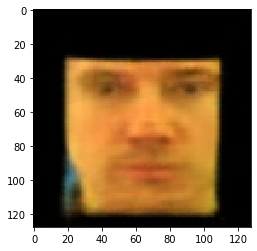

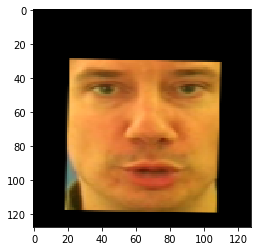

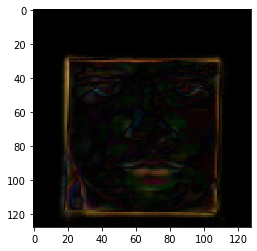

In [45]:
plt.imshow(out)
plt.show()
plt.imshow(target)
plt.show()
plt.imshow(diff)
plt.show()

In [34]:
np.max(diff)

0.5083602

In [46]:
out.shape

(128, 128, 3)

In [49]:
out[:,:,:10,:10] = 1